# Ensemble: variables (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.local
import libs.plot
import libs.vars
import matplotlib
import numpy as np

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = 'precipitation, rainfall (dashed), and snowfall (dotted) over sea-ice'
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 1.5)
time_series_y_range_monthly = (0, 2)
time_series_y_range_regional = (0, 3)
time_series_process = lambda x: x

In [3]:
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }


ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series('pr', experiment)
)
ensemble_pr_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('pr', experiment, suffix='_smooth')
)


ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment, suffix='_smooth')
)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }
    ensemble_prsn_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


ensemble_evspsbl_time_series = time_series_process(
    libs.local.get_ensemble_series('evspsbl', experiment)
)
ensemble_evspsbl_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('evspsbl', experiment, suffix='_smooth')
)

for variable in ensemble_evspsbl_time_series:
    ensemble_evspsbl_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }
    ensemble_evspsbl_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


ensemble_tas_time_series = time_series_process(
    libs.local.get_ensemble_series('tas', experiment)
)
ensemble_tas_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('tas', experiment, suffix='_smooth')
)

ensemble_tas_time_series /= 10
ensemble_tas_time_series_smooth /= 10

for variable in ensemble_tas_time_series:
    ensemble_tas_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_tas_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    

ensemble_siconc_time_series = time_series_process(
    libs.local.get_ensemble_series('siconc', experiment)
)
ensemble_siconc_time_series /= 1e7

for variable in ensemble_siconc_time_series:
    ensemble_siconc_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


ensemble_sithick_time_series = time_series_process(
    libs.local.get_ensemble_series('sithick', experiment)
)
ensemble_sithick_time_series /= 5

ensemble_sisnthick_time_series = time_series_process(
    libs.local.get_ensemble_series('sisnthick', experiment)
)
ensemble_sisnthick_time_series *= 5

ensemble_simass_time_series = time_series_process(
    libs.local.get_ensemble_series('simass', experiment)
)

time_slices = libs.vars.default_time_slices()

## Monthly variability

### Full region (time)

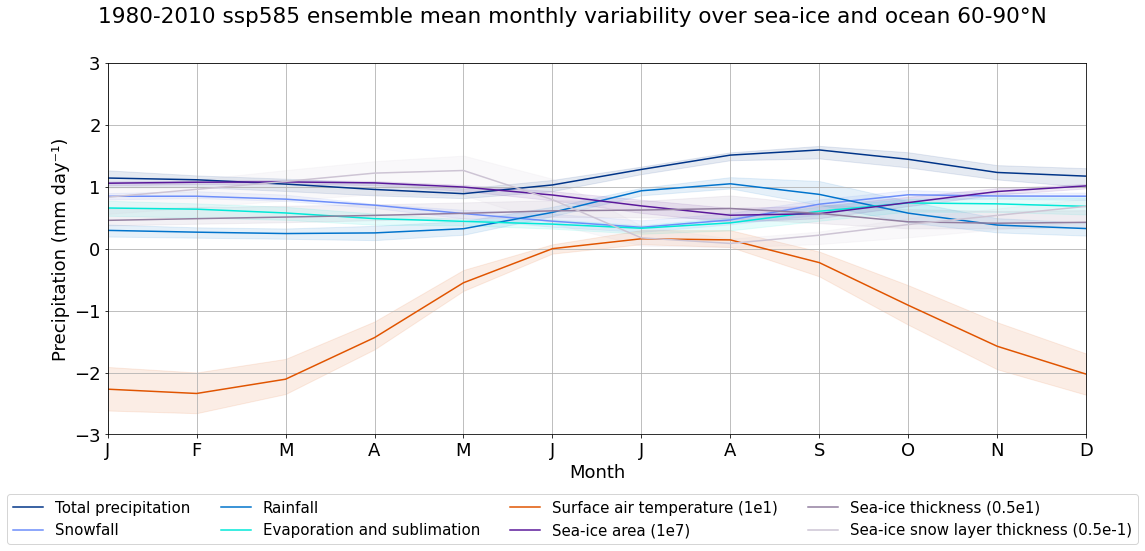

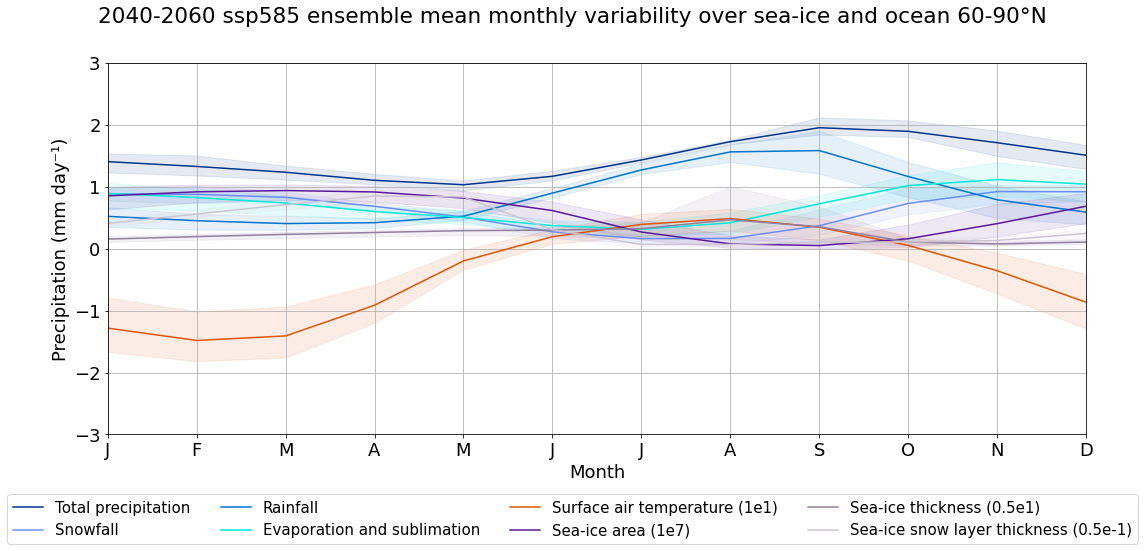

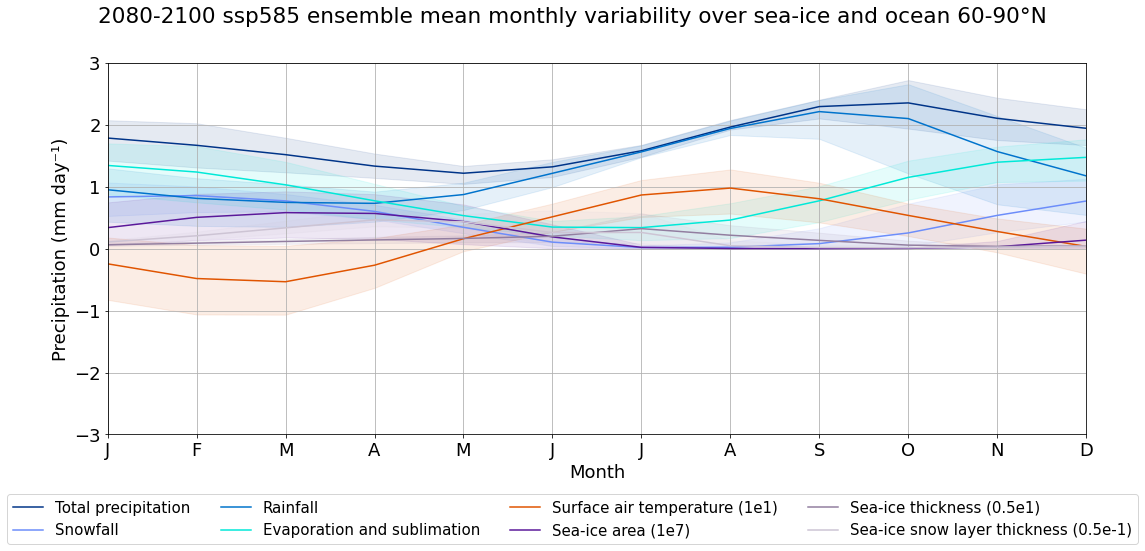

In [4]:
import numpy as np

for s in time_slices:
    s_label = s['label']
    
    slice_pr = ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_pr['Ensemble mean'].attrs['label'] = 'Total precipitation'
    slice_pr['Ensemble mean'].attrs['color'] = '#003488'
    
    slice_prsn = ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_prsn['Ensemble mean'].attrs['label'] = 'Snowfall'
    slice_prsn['Ensemble mean'].attrs['color'] = '#6c8dfa'
    del slice_prsn['Ensemble mean'].attrs['plot_kwargs']
    
    slice_prra = ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_prra['Ensemble mean'].attrs['label'] = 'Rainfall'
    slice_prra['Ensemble mean'].attrs['color'] = '#0073cc'
    del slice_prra['Ensemble mean'].attrs['plot_kwargs']
    
    slice_evspsbl = ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_evspsbl['Ensemble mean'].attrs['label'] = 'Evaporation and sublimation'
    slice_evspsbl['Ensemble mean'].attrs['color'] = '#00e9d8'
    del slice_evspsbl['Ensemble mean'].attrs['plot_kwargs']
    
    slice_tas = ensemble_tas_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_tas['Ensemble mean'].attrs['label'] = 'Surface air temperature (1e1)'
    slice_tas['Ensemble mean'].attrs['color'] = '#e05400'
    del slice_tas['Ensemble mean'].attrs['plot_kwargs']
    
    slice_siconc = ensemble_siconc_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_siconc['Ensemble mean'].attrs['label'] = 'Sea-ice area (1e7)'
    slice_siconc['Ensemble mean'].attrs['color'] = '#5a189a'
    del slice_siconc['Ensemble mean'].attrs['plot_kwargs']
    
    slice_sithick = ensemble_sithick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_sithick['Ensemble mean'].attrs['label'] = 'Sea-ice thickness (0.5e1)'
    slice_sithick['Ensemble mean'].attrs['color'] = '#927EA0'
    
    slice_sisnthick = ensemble_sisnthick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_sisnthick['Ensemble mean'].attrs['label'] = 'Sea-ice snow layer thickness (0.5e-1)'
    slice_sisnthick['Ensemble mean'].attrs['color'] = '#CDC4D4'
    
    variables = [
        slice_pr,
        slice_prsn,
        slice_prra,
        slice_evspsbl,
        slice_tas,
        slice_siconc,
        slice_sithick,
        slice_sisnthick
    ]
    
    fig = libs.plot.monthly_variability(
        variables,
        cols=4,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean monthly variability over sea-ice and ocean 60-90°N',
        ylabel=time_series_y_label,
        yrange=(-3, 3), #time_series_y_range_monthly
        variables=['Ensemble mean']
    )
        
    for data in variables:
        data_min = data.to_array('min').min('min')
        data_max = data.to_array('max').max('max')
        
        fig.axes[0].fill_between(
            np.arange(1, 13),
            data_min.values,
            data_max.values,
            alpha=0.1,
            color=data['Ensemble mean'].attrs['color'],
            zorder=-1
        )

### Full region (each model)

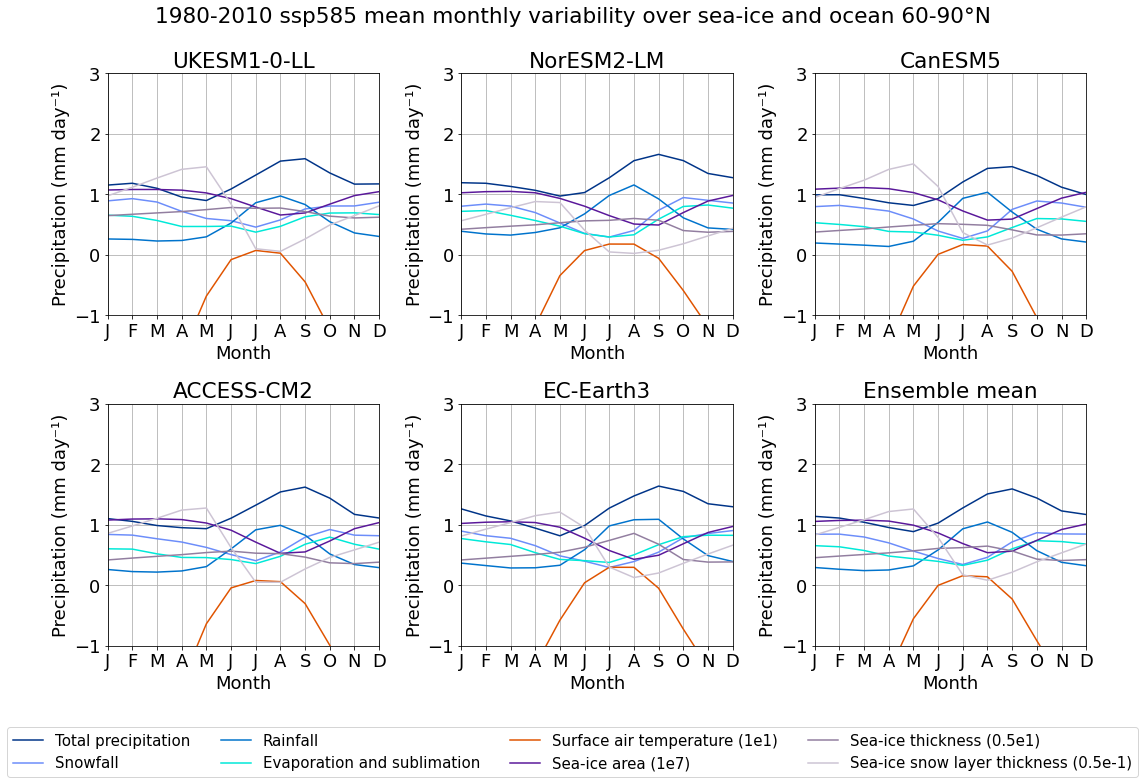

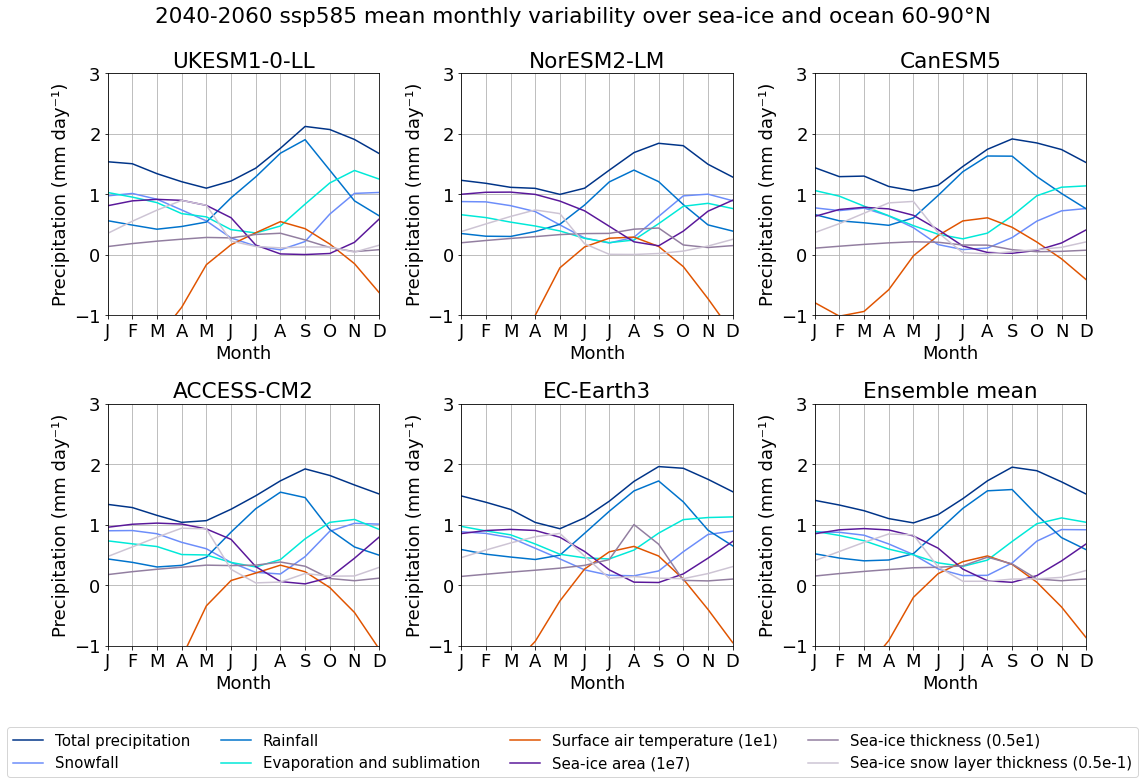

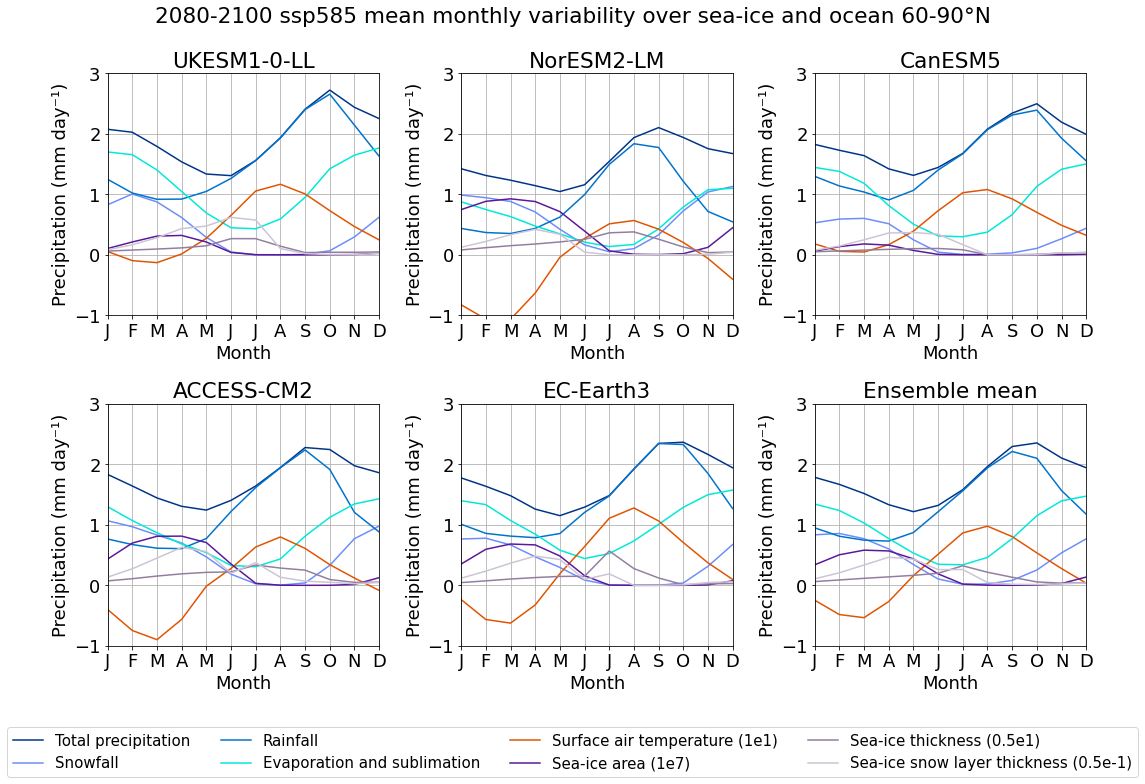

In [5]:
for s in time_slices:
    s_label = s['label']
    arr = []

    for model in ensemble_pr_time_series:      
        slice_pr = ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_pr[model].attrs['label'] = 'Total precipitation'
        slice_pr[model].attrs['color'] = '#003488'

        slice_prsn = ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_prsn[model].attrs['label'] = 'Snowfall'
        slice_prsn[model].attrs['color'] = '#6c8dfa'
        del slice_prsn[model].attrs['plot_kwargs']

        slice_prra = ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_prra[model].attrs['label'] = 'Rainfall'
        slice_prra[model].attrs['color'] = '#0073cc'
        del slice_prra[model].attrs['plot_kwargs']
        
        slice_evspsbl = ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_evspsbl[model].attrs['label'] = 'Evaporation and sublimation'
        slice_evspsbl[model].attrs['color'] = '#00e9d8'
        del slice_evspsbl[model].attrs['plot_kwargs']

        slice_tas = ensemble_tas_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_tas[model].attrs['label'] = 'Surface air temperature (1e1)'
        slice_tas[model].attrs['color'] = '#e05400'
        del slice_tas[model].attrs['plot_kwargs']

        slice_siconc = ensemble_siconc_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_siconc[model].attrs['label'] = 'Sea-ice area (1e7)'
        slice_siconc[model].attrs['color'] = '#5a189a'
        del slice_siconc[model].attrs['plot_kwargs']

        slice_sithick = ensemble_sithick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_sithick[model].attrs['label'] = 'Sea-ice thickness (0.5e1)'
        slice_sithick[model].attrs['color'] = '#927EA0'

        slice_sisnthick = ensemble_sisnthick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_sisnthick[model].attrs['label'] = 'Sea-ice snow layer thickness (0.5e-1)'
        slice_sisnthick[model].attrs['color'] = '#CDC4D4'
        
        model_variables = [
            slice_pr[model],
            slice_prsn[model],
            slice_prra[model],
            slice_evspsbl[model],
            slice_tas[model],
            slice_siconc[model],
            slice_sithick[model],
            slice_sisnthick[model]
        ]

        arr.append(model_variables)

    libs.plot.monthly_variability_model(
        arr,
        cols=4,
        legend_below=True,
        shape=(2, 3),
        title=f'{s_label} {experiment} mean monthly variability over sea-ice and ocean 60-90°N',
        ylabel=time_series_y_label,
        yrange=(-1, 3), #time_series_y_range_monthly
    )

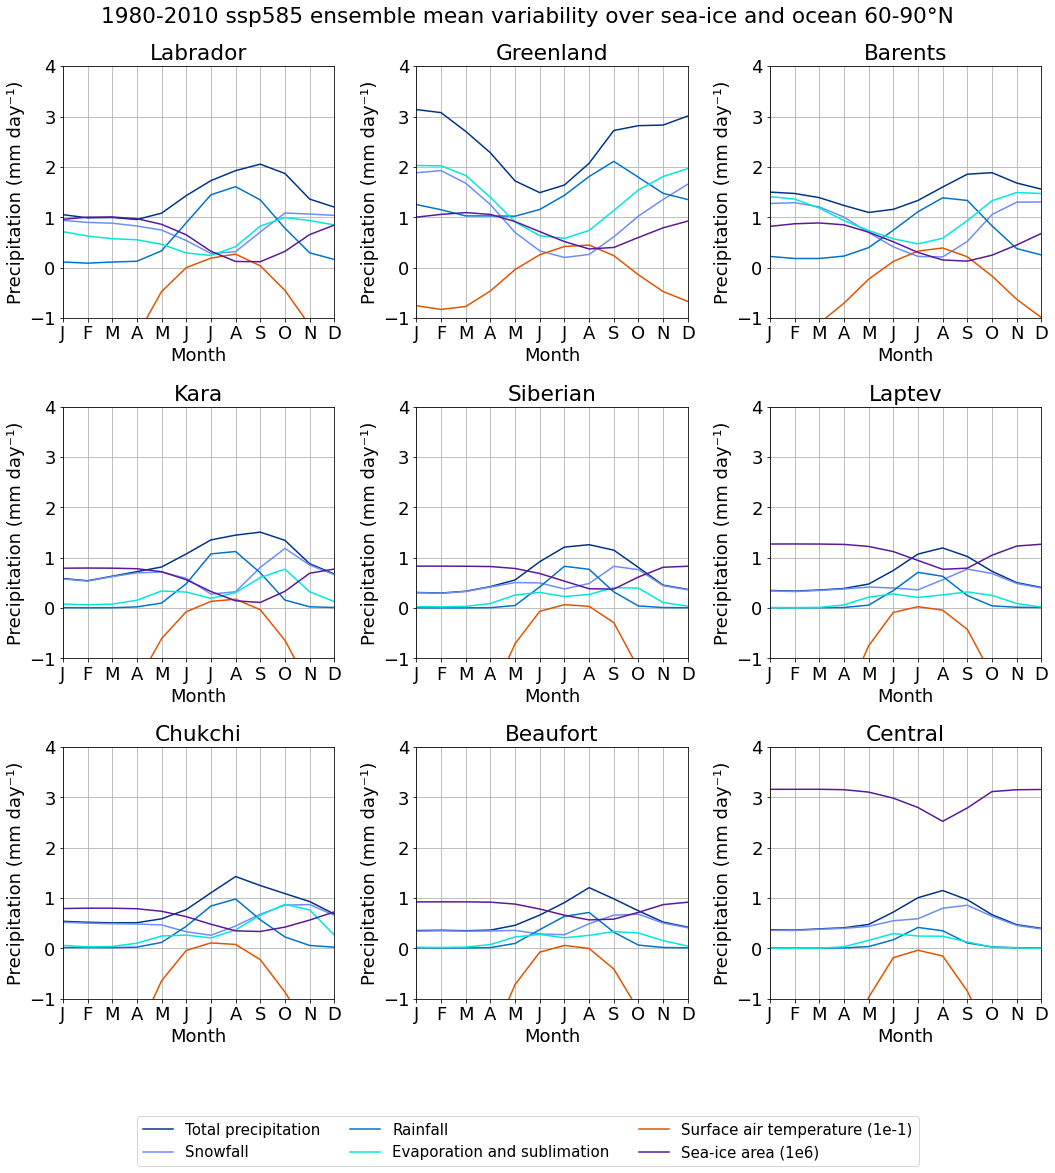

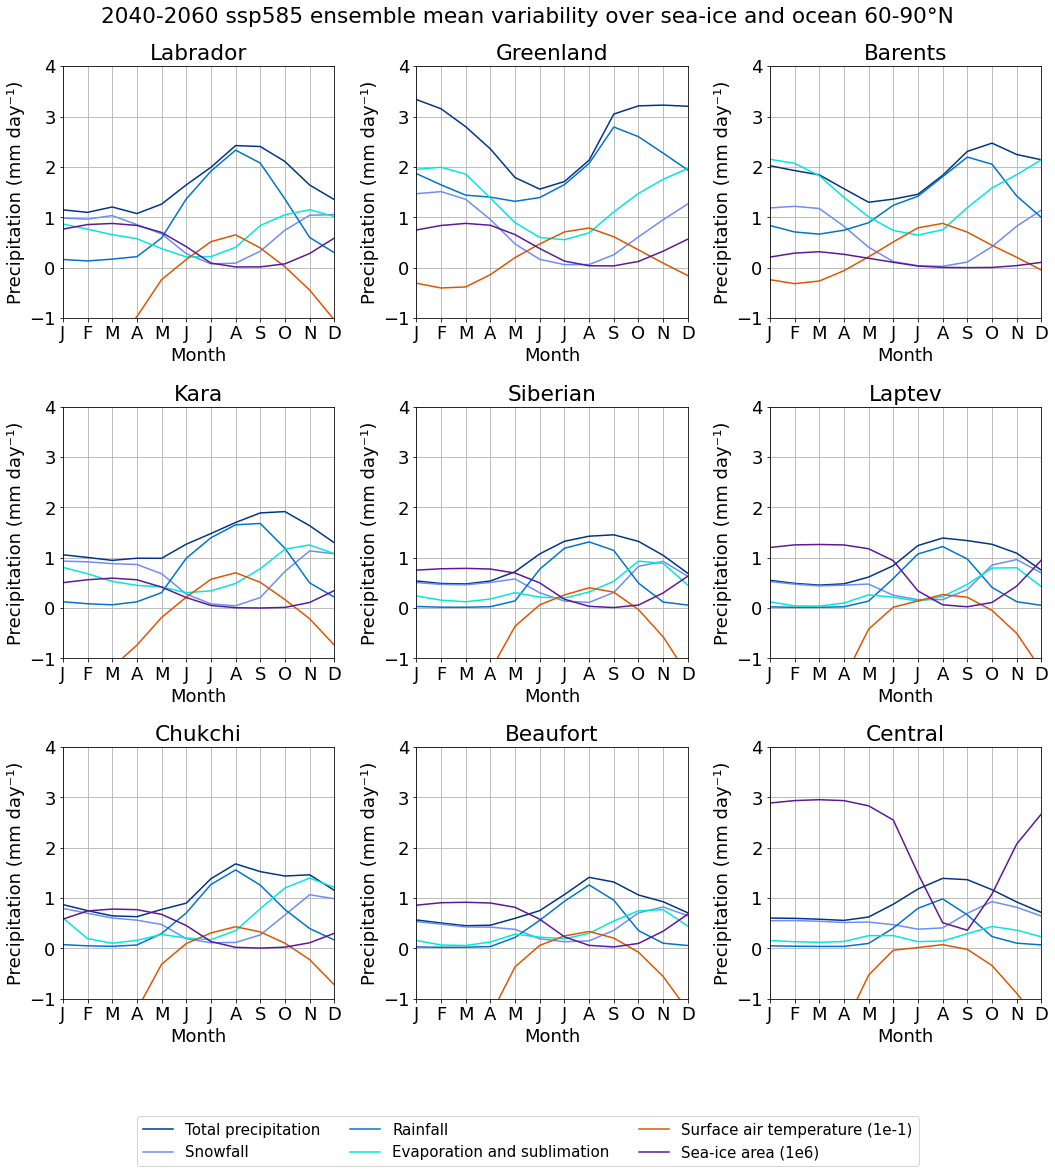

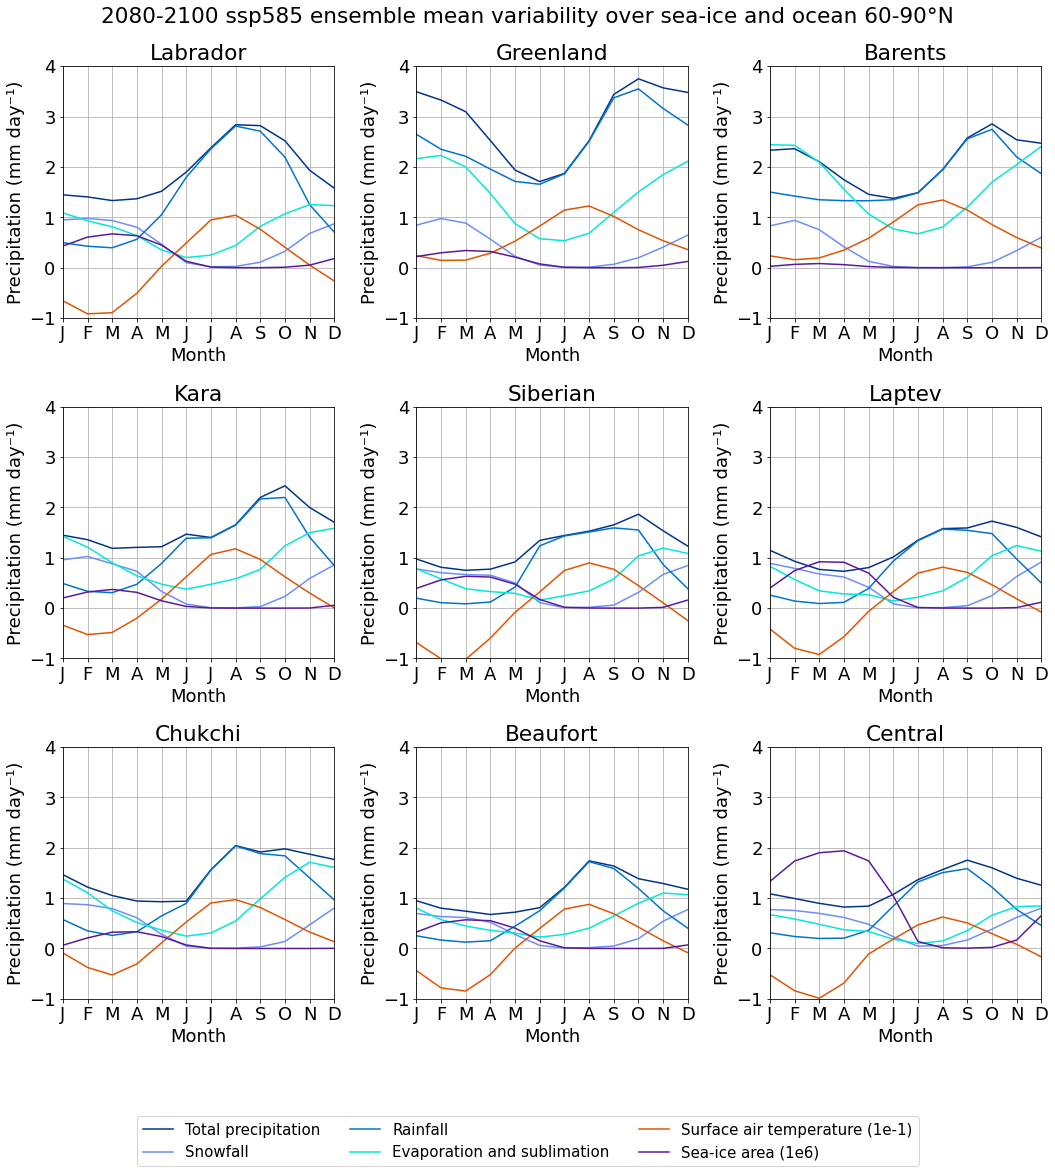

In [6]:
regions_pr = libs.local.get_ensemble_regional_series('pr', experiment)
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn', experiment)
regions_evspsbl = libs.local.get_ensemble_regional_series('evspsbl', experiment)
regions_tas = libs.local.get_ensemble_regional_series('tas', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data_prra in enumerate(regions_prra):
        data_pr_slice = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_slice['Ensemble mean'].attrs['label'] = 'Total precipitation'
        data_pr_slice['Ensemble mean'].attrs['color'] = '#003488'
        
        data_prsn_slice = regions_prsn[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_prsn_slice['Ensemble mean'].attrs['label'] = 'Snowfall'
        data_prsn_slice['Ensemble mean'].attrs['color'] = '#6c8dfa'
        
        data_prra_slice = data_prra.sel(**s['slice']).groupby('time.month').mean('time')
        data_prra_slice['Ensemble mean'].attrs['label'] = 'Rainfall'
        data_prra_slice['Ensemble mean'].attrs['color'] = '#0073cc'
        
        data_evspsbl_slice = regions_evspsbl[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_evspsbl_slice['Ensemble mean'].attrs['label'] = 'Evaporation and sublimation'
        data_evspsbl_slice['Ensemble mean'].attrs['color'] = '#00e9d8'

        data_siconc_slice = regions_siconc[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_siconc_slice /= 1e6
        data_siconc_slice['Ensemble mean'].attrs['label'] = 'Sea-ice area (1e6)'
        data_siconc_slice['Ensemble mean'].attrs['color'] = '#5a189a'

        data_tas_slice = regions_tas[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_tas_slice /= 10
        data_tas_slice['Ensemble mean'].attrs['label'] = 'Surface air temperature (1e-1)'
        data_tas_slice['Ensemble mean'].attrs['color'] = '#e05400'

        arr.append([
            data_pr_slice,
            data_prsn_slice,
            data_prra_slice,
            data_evspsbl_slice,
            data_tas_slice,
            data_siconc_slice
        ])

    libs.plot.monthly_variability_regional(
        arr,
        cols=3,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean variability over sea-ice and ocean 60-90°N',
        variables=['Ensemble mean'],
        ylabel=time_series_y_label,
        yrange=(-1, 4)
    )